In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn import metrics
import seaborn as sns
import re
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,roc_curve,confusion_matrix
import ast

RANDOM_STATE = 4222

In [4]:
EMBEDDING_FILE = "glove.42B.300d.txt"
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index_profiles = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [5]:
numdim = embeddings_index_profiles[next(iter(embeddings_index_profiles))].shape[0]

In [6]:
dftrain = pd.read_csv('datasets/train_and_test/train.csv')
dftest = pd.read_csv("datasets/train_and_test/test.csv")

In [8]:
dftrain.head()

,Unnamed: 0,title,company_profile,description,requirements,benefits,title_tokens,company_profile_tokens,description_tokens,requirements_tokens,...,spelling_errors_title,spelling_errors_company_profile,spelling_errors_description,spelling_errors_requirements,spelling_errors_benefits,special_characters_title,special_characters_company_profile,special_characters_description,special_characters_requirements,special_characters_benefits
0,12457,Surveyors / Order Takers,Not specified,Get paid $12 per hour to walk 3 miles per day....,Customer service skills are required. We train...,Great hourly pay as well as bonuses with no se...,"['Surveyors', '/', 'Order', 'Takers']","['Not', 'specified']","['Get', 'paid', '$', '12', 'per', 'hour', 'to'...","['Customer', 'service', 'skills', 'are', 'requ...",...,-0.365733,-0.430176,-0.454923,-0.814619,-0.435584,0.288249,-0.838066,0.193859,-0.615274,-0.424361
1,4961,Graphics Artist,Itsa Southern Thing Apparel owns several cloth...,Can you draw absolutely anything? Can you hand...,College degree strongly preferred.Degree from ...,"$32,000 salaryHealth InsuranceReitement matchi...","['Graphics', 'Artist']","['Itsa', 'Southern', 'Thing', 'Apparel', 'owns...","['Can', 'you', 'draw', 'absolutely', 'anything...","['College', 'degree', 'strongly', 'preferred.D...",...,-0.365733,0.100974,-0.560832,-0.814619,0.502864,-0.625359,0.064432,-0.724905,-0.559153,-0.332475
2,8992,Graduates: English Teacher Abroad (Conversatio...,We help teachers get safe & secure jobs abroad :),"Play with kids, get paid for itLove travel? Jo...",University degree required.TEFL / TESOL / CELT...,See job description,"['Graduates', ':', 'English', 'Teacher', 'Abro...","['We', 'help', 'teachers', 'get', 'safe', '&',...","['Play', 'with', 'kids', ',', 'get', 'paid', '...","['University', 'degree', 'required.TEFL', '/',...",...,-0.365733,-0.430176,-0.349013,-0.512111,-0.435584,2.115465,-0.657567,-0.549902,-0.503032,-0.516246
3,4273,Android Developer,Not specified,"Certoid is an identity, impersonation and repu...",Not specified,Not specified,"['Android', 'Developer']","['Not', 'specified']","['Certoid', 'is', 'an', 'identity', ',', 'impe...","['Not', 'specified']",...,-0.365733,-0.430176,-0.031283,-0.814619,-0.435584,-0.625359,-0.838066,0.281360,-0.783636,-0.516246
4,15766,Global Business Development Manager,Playfair Capital is an early stage technology ...,The Business Development Manager at Birdback i...,Outstanding degree from a leading University ...,"Here at Birdback, we work hard, we laugh a lot...","['Global', 'Business', 'Development', 'Manager']","['Playfair', 'Capital', 'is', 'an', 'early', '...","['The', 'Business', 'Development', 'Manager', ...","['Outstanding', 'degree', 'from', 'a', 'leadin...",...,-0.365733,-0.297389,0.180537,-0.663365,3.083594,-0.625359,-0.777900,-0.637403,-0.503032,2.791636


In [9]:
dftest.head()

,Unnamed: 0,title,company_profile,description,requirements,benefits,title_tokens,company_profile_tokens,description_tokens,requirements_tokens,...,spelling_errors_title,spelling_errors_company_profile,spelling_errors_description,spelling_errors_requirements,spelling_errors_benefits,special_characters_title,special_characters_company_profile,special_characters_description,special_characters_requirements,special_characters_benefits
0,9110,Outbound Sales Agent,EROAD was established to modernise New Zealand...,"EROAD is a fully integrated technology, road c...",Requirements:At least two years experience in ...,"EROAD offers a competitive salary, career deve...","['Outbound', 'Sales', 'Agent']","['EROAD', 'was', 'established', 'to', 'moderni...","['EROAD', 'is', 'a', 'fully', 'integrated', 't...","['Requirements', ':', 'At', 'least', 'two', 'y...",...,-0.353965,0.862070,-0.533651,-0.237465,-0.230794,-0.615409,0.537045,-0.556736,-0.356575,-0.055460
1,6387,Acquire Users / Customers (Marketing & Sales),Point Nine Capital is a Berlin-based venture c...,Sounds like what you are looking for? Then app...,Not specified,Not specified,"['Acquire', 'Users', '/', 'Customers', '(', 'M...","['Point', 'Nine', 'Capital', 'is', 'a', 'Berli...","['Sounds', 'like', 'what', 'you', 'are', 'look...","['Not', 'specified']",...,-0.353965,0.604895,-0.919225,-0.827068,-0.527352,2.915603,0.083913,-0.919144,-0.821966,-0.552016
2,8124,English Teacher Abroad,We help teachers get safe & secure jobs abroad :),"Play with kids, get paid for itLove travel? Jo...",University degree required.TEFL / TESOL / CELT...,See job description,"['English', 'Teacher', 'Abroad']","['We', 'help', 'teachers', 'get', 'safe', '&',...","['Play', 'with', 'kids', ',', 'get', 'paid', '...","['University', 'degree', 'required.TEFL', '/',...",...,-0.353965,-0.423807,-0.405126,-0.679668,-0.527352,-0.615409,-0.570610,-0.556736,-0.589271,-0.552016
3,2295,PT Prep/Cook,Lafayette Habilitation Center creates a unique...,Essential Functions1. Tray set-up according to...,Required Education & Experience1. High School ...,Direct depositOn site in-service training to d...,"['PT', 'Prep/Cook']","['Lafayette', 'Habilitation', 'Center', 'creat...","['Essential', 'Functions1', '.', 'Tray', 'set-...","['Required', 'Education', '&', 'Experience1', ...",...,-0.353965,-0.423807,1.651269,0.204737,0.065763,0.267344,-0.469914,0.575789,0.399685,-0.452705
4,11724,JAVA/J2EE developer,EUROPEAN DYNAMICS () is a leading European Sof...,We currently have a vacancy for JAVA/J2EE deve...,Your skills:University degree with minimum 2 y...,Our offer: If you are seeking a career in an e...,"['JAVA/J2EE', 'developer']","['EUROPEAN', 'DYNAMICS', '(', ')', 'is', 'a', ...","['We', 'currently', 'have', 'a', 'vacancy', 'f...","['Your', 'skills', ':', 'University', 'degree'...",...,-0.353965,-0.295220,-0.790700,1.236542,-0.230794,0.267344,0.688089,-0.330231,0.574207,2.129386


In [10]:
df_train = dftrain.drop(dftrain.columns[0],axis=1)
df_test = dftest.drop(dftest.columns[0],axis=1)

In [11]:
smote = SMOTE(random_state=RANDOM_STATE)
x_df_train = df_train.drop(['fraudulent','title','company_profile','description','requirements','benefits','title_tokens','company_profile_tokens','description_tokens','requirements_tokens','benefits_tokens'],axis=1)
y_df_train = df_train['fraudulent']

X_df_resampled,Y_resampled = smote.fit_resample(x_df_train,y_df_train)


In [12]:
def getcosinesimilaritytrain(column):
    job_descriptions_all = df_train[column].apply(ast.literal_eval).apply(lambda x: ' '.join(x)).values
    job_embeddings_all = np.zeros((len(job_descriptions_all), numdim))
    for i, description in enumerate(job_descriptions_all):
        words = description.split()
        embeddings = [embeddings_index_profiles.get(word, np.zeros(numdim)) for word in words]
        if len(words) == 0:
            job_embeddings_all[i] = np.zeros(numdim)
        else:
            job_embeddings_all[i] = np.mean(embeddings, axis=0)
    
    #PERFORM SMOTE
    column_resampled,Y_resampled = smote.fit_resample(job_embeddings_all,y_df_train)
    job_embeddings_fraud = column_resampled[Y_resampled == 1]      
    cos_sim_matrix = cosine_similarity(column_resampled,job_embeddings_fraud)
    cos_sim_highest = []
    for i in range(cos_sim_matrix.shape[0]):
        #return the second highest and not max because returning max would be info leakage (as max cosine-similarity will definitely be 1, which is the job posting itself)
        cos_sim_highest.append(np.sort(cos_sim_matrix[i])[-2])
    return cos_sim_highest

def getcosinesimilaritytest(column):
    job_descriptions_all = df_test[column].apply(ast.literal_eval).apply(lambda x: ' '.join(x)).values
    job_embeddings_all = np.zeros((len(job_descriptions_all), numdim))
    for i, description in enumerate(job_descriptions_all):
        words = description.split()
        embeddings = [embeddings_index_profiles.get(word, np.zeros(numdim)) for word in words]
        if len(words) == 0:
            job_embeddings_all[i] = np.zeros(numdim)
        else:
            job_embeddings_all[i] = np.mean(embeddings, axis=0)

    job_embeddings_fraud = job_embeddings_all[df_test['fraudulent'] == 1] 
    cos_sim_matrix = cosine_similarity(job_embeddings_all,job_embeddings_fraud)
    cos_sim_highest = []
    for i in range(cos_sim_matrix.shape[0]):
        #return the second highest and not max because returning max would be info leakage (as max cosine-similarity will definitely be 1, which is the job posting itself)
        cos_sim_highest.append(np.sort(cos_sim_matrix[i])[-2])
    return cos_sim_highest

def process(column,newcolumn):
    train_cosine_similarity = getcosinesimilaritytrain(column)
    X_df_resampled[newcolumn] = train_cosine_similarity
    test_cosine_similarity = getcosinesimilaritytest(column)
    df_test[newcolumn] = test_cosine_similarity

In [13]:
process('title_tokens','cosine_similarity_title')

In [14]:
process('company_profile_tokens','cosine_similarity_companyprofile')

In [15]:
process('description_tokens','cosine_similarity_description')

In [16]:
process('requirements_tokens','cosine_similarity_requirements')

In [17]:
process('benefits_tokens','cosine_similarity_benefits')

In [18]:
x_df_test = df_test.drop(['fraudulent','title','company_profile','description','requirements','benefits','title_tokens','company_profile_tokens','description_tokens','requirements_tokens','benefits_tokens'],axis=1)
y_df_test = df_test['fraudulent']

In [19]:
params_xgb = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7]
}

model_xgb = XGBClassifier()
grid_search_xgb = GridSearchCV(model_xgb, param_grid=params_xgb, cv=5,n_jobs=-1)
grid_search_xgb.fit(X_df_resampled, Y_resampled)

best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(x_df_test)

In [20]:
def get_confusion_matrix(actual, predicted, title):
    cf = metrics.confusion_matrix(actual, predicted)
    group_names = ['True Negative','False Positive','False Negative','True Positive'] 
    group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()] 

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    s = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues', xticklabels=['non fraud', 'fraud'], yticklabels=['non fraud', 'fraud'])
    s.set(xlabel='Predictions', ylabel='True Labels', title=title)
    return s

<AxesSubplot: title={'center': 'XGBoost'}, xlabel='Predictions', ylabel='True Labels'>

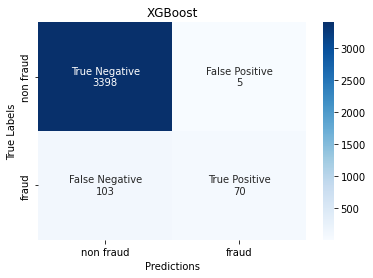

In [21]:
get_confusion_matrix(y_df_test, y_pred_xgb, "XGBoost")

In [22]:
d_xgb = {
    'Recall': [metrics.recall_score(y_df_test,y_pred_xgb)],
    'Precision': [metrics.precision_score(y_df_test,y_pred_xgb)],
    'F1-Score': [metrics.f1_score(y_df_test,y_pred_xgb)],
    'Accuracy': [metrics.accuracy_score(y_df_test,y_pred_xgb)],
    'ROC AUC': [metrics.roc_auc_score(y_df_test,y_pred_xgb)],
}

df_metrics_xgb = pd.DataFrame(d_xgb)
df_metrics_xgb

,Recall,Precision,F1-Score,Accuracy,ROC AUC
0,0.404624,0.933333,0.564516,0.969799,0.701577
